<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports-and-setup-functions" data-toc-modified-id="Imports-and-setup-functions-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports and setup functions</a></span></li><li><span><a href="#Get-data-from-server" data-toc-modified-id="Get-data-from-server-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Get data from server</a></span></li><li><span><a href="#Read-and-process-NetCDF-files" data-toc-modified-id="Read-and-process-NetCDF-files-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Read and process NetCDF files</a></span><ul class="toc-item"><li><span><a href="#Methods" data-toc-modified-id="Methods-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Methods</a></span></li><li><span><a href="#Test:-Read-data-from-2021" data-toc-modified-id="Test:-Read-data-from-2021-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Test: Read data from 2021</a></span></li><li><span><a href="#Surface-temperature" data-toc-modified-id="Surface-temperature-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Surface temperature</a></span></li><li><span><a href="#Choose-window-over-geographic-area" data-toc-modified-id="Choose-window-over-geographic-area-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Choose window over geographic area</a></span></li><li><span><a href="#Slice-images-to-size" data-toc-modified-id="Slice-images-to-size-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Slice images to size</a></span></li></ul></li><li><span><a href="#Exploratory-Analysis" data-toc-modified-id="Exploratory-Analysis-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Exploratory Analysis</a></span></li></ul></div>

# Imports and setup functions

In [1]:
import os
from matplotlib import pyplot as plt
import numpy as np
import netCDF4 as nc
import ftplib
import math

In [2]:
def dataDir(x):
    cwd = os.getcwd()
    
    return cwd + "/data/" + x

# Get data from server

In [3]:
## Create connection to FTP

def access_to_server(USERNAME,PASSWORD, PRODUCT_ID, DATASET_ID):
    # Access to ftp server
    HOSTNAME = ['nrt.cmems-du.eu', 'my.cmems-du.eu']
    try: 
        # NRT server 
        ftp = ftplib.FTP(HOSTNAME[0], USERNAME, PASSWORD)
        ftp.encoding = "utf-8"
        # Move to dataset directory
        ftp.cwd(f'Core/{PRODUCT_ID}/{DATASET_ID}')
    except:
        # MY server
        ftp = ftplib.FTP(HOSTNAME[1], USERNAME, PASSWORD)
        ftp.encoding = "utf-8"
        # Move to dataset directory
        ftp.cwd(f'Core/{PRODUCT_ID}/{DATASET_ID}')
    return ftp 


## Browse and download

def download_ftp_tree(ftp,OUTDIR):
    # Create directory if doesn't exist
    if not os.path.exists(OUTDIR):
        os.makedirs(OUTDIR)
    # Save the initial directory
    original_cwd = ftp.pwd()
    # Show the content of the FTP_address directory
    ftp_content = ftp.nlst()
    for fc in ftp_content:
        try: 
        # check if fc is a directory and create a local subfolder with the same name
            ftp.cwd(f'{fc}')
            print(f'{fc}')
            if not os.path.exists(f'{OUTDIR}/{fc}'):
                os.makedirs(f'{OUTDIR}/{fc}')
                print(f'{OUTDIR}/{fc} is now created')
            download_ftp_tree(ftp,f'{OUTDIR}/{fc}')
            ftp.cwd(original_cwd)
        except: 
        # fc is not a directory but a file, so it's downloaded in its local subfolder
            local_filename = os.path.join(f'{OUTDIR}', fc)
            file = open(local_filename, 'wb')
            ftp.retrbinary('RETR '+ fc, file.write)
            file.close()

In [4]:
HOST = "my.cmems-du.eu"

USERNAME = "lvilallonga"
PASSWORD = "dumbPW0123"

PRODUCT_ID = "IBI_ANALYSISFORECAST_PHY_005_001" 
DATASET_ID = "cmems_mod_ibi_phy_anfc_0.027deg-3D_P1D-m" 
OUT_DIR = dataDir("IBI_ANALYSISFORECAST_PHY_005_001")

In [5]:
FTP = access_to_server(USERNAME, PASSWORD, PRODUCT_ID, DATASET_ID)
    
# Download the content of the dataset
download_ftp_tree(FTP, OUT_DIR)
print('Download complete!')
    
# Closure 
FTP.close()

2020
/home/lucia/projects/FORMES/rainfall-pde-ml/data/IBI_ANALYSISFORECAST_PHY_005_001/2020 is now created
11
/home/lucia/projects/FORMES/rainfall-pde-ml/data/IBI_ANALYSISFORECAST_PHY_005_001/2020/11 is now created
12
/home/lucia/projects/FORMES/rainfall-pde-ml/data/IBI_ANALYSISFORECAST_PHY_005_001/2020/12 is now created
2021
/home/lucia/projects/FORMES/rainfall-pde-ml/data/IBI_ANALYSISFORECAST_PHY_005_001/2021 is now created
01
/home/lucia/projects/FORMES/rainfall-pde-ml/data/IBI_ANALYSISFORECAST_PHY_005_001/2021/01 is now created
02
/home/lucia/projects/FORMES/rainfall-pde-ml/data/IBI_ANALYSISFORECAST_PHY_005_001/2021/02 is now created
03
/home/lucia/projects/FORMES/rainfall-pde-ml/data/IBI_ANALYSISFORECAST_PHY_005_001/2021/03 is now created
04
/home/lucia/projects/FORMES/rainfall-pde-ml/data/IBI_ANALYSISFORECAST_PHY_005_001/2021/04 is now created
05
/home/lucia/projects/FORMES/rainfall-pde-ml/data/IBI_ANALYSISFORECAST_PHY_005_001/2021/05 is now created
06
/home/lucia/projects/FORMES

# Read and process NetCDF files

## Methods

In [29]:
def create_dataset(year, month_path):
    
    dataset = {}
    
    d_paths = [month_path + "/" + d for d in os.listdir(month_path)]
    d_paths.sort()
    
    print("Creating dataset from month: " + month_path[-2:] + "...")
    
    for d in d_paths:
        
        # Create ID
        d_id = "sst_" + str(year) + "-" + month_path[-2:] + "-" + d[-20:-18]
        
        # Read data into Dataset
        #print("...Day: " + d[-20:-18] + "...")
        
        d_nc = nc.Dataset(d)
       
        # Save to dictionary with datasets
        dataset[d_id] = d_nc
        
    return dataset

In [7]:
def get_surface_value(data):
    """Method to extract the first level of depth for which there is data.
        
       Parameters
       ----------
       data : numpy.ndarray or numpy.ma.core.MaskedArray
    
    """
    #data_c = data.copy() 
    
    return data[0, :, :] #data_c[0, :, :]

In [25]:
def surface_all(dataset, var="thetao"):
    """
       Parameters
       ----------
       dataset : dict
    """
    
    print("Extracting surface observations only...")
    
    red_dataset = {}
    
    for k in dataset.keys():
        item = dataset[k][var][0]
        
        red_item = get_surface_value(item)
        red_key = "red_" + k 
        red_dataset[red_key] = red_item
        
    return red_dataset

In [9]:
def select_geo_area(img, latmin, latmax, lonmin, lonmax, var="thetao"):
    """
       Parameters
       ----------
       img : netCDF4.Dataset
       latmin : float
       latmax : float
       lonmin : float
       lonmax : float
       var : str 
    """
    
    lat, lon = img.variables["latitude"][:], img.variables["longitude"][:]
    v = img[var][0]
    
    lat_mask = np.where((lat < latmax) & (lat > latmin), True, False)
    lon_mask = np.where((lon < lonmax) & (lon > lonmin), True, False)
    
    var_slice = []
    
    for d in range(len(v)): # iterate over depth
        var_slice.append(v[d,][lat_mask,:][:,lon_mask])

    return np.ma.masked_array(var_slice)

In [10]:
def select_all(dataset, latmin, latmax, lonmin, lonmax, var="thetao"):
    """
       Parameters
       ----------
       dataset : dict
    """
    
    area_dataset = {}
    
    for k in dataset.keys():
        item = dataset[k]
        
        area_item = select_geo_area(item, latmin, latmax, lonmin, lonmax, var)
        area_key = k
        area_dataset[area_key] = area_item
        
    return area_dataset
    
    pass

In [11]:
def slice_img(img, end_shape):
    """
       Parameters
       ----------
       img : numpy.ndarray or numpy.ma.core.MaskedArray
       end_shape : tuple
    """
    
    slice_dataset = {}
    M, N = end_shape[0], end_shape[1]
    m, n = img.shape[0], img.shape[1]
    
    assert (m > M) & (n > N), "Image too small for desired slice."
        
    
    n_regions = math.floor(m / M) * math.floor(n / N)
    
    starti = 0
    endi = M
    startj = 0
    endj = N
    
    print("Slicing image into " + str(n_regions) + " regions...")
    
    for i in range(math.floor(m / M)):
        for j in range(math.floor(n / N)):
            
            #print("Region: " + str(i) + str(j))
            slice_key = "region_" + str(i) + str(j)
                        
            slice_dataset[slice_key] = img[starti:endi, startj:endj]
            
            startj = endj
            endj += N
        
        starti = endi
        endi += M
            
    return slice_dataset

In [30]:
def process_all(top_path): #, lat, lon, latmin, latmax, lonmin, lonmax, var="thetao", end_shape=(256,256)):
    
    # (done) iterate over years in top_path
    # (done) iterate over months in year_paths
    # (done) call create_dataset for each month
    # for each dataset, get surface temperature  <- memory cutoff
    # for each dataset, select geo area
    # for each dataset, slice into 256x256 regions
    # collate all regions 
    
    """
       Parameters
       ----------
       top_path :  str
       lat : tuple
       lon : tuple
       var : str
       end_shape : tuple
    """
    
    region_series = []
    month_data = []
    
    year_paths = [top_path + "/" + y for y in os.listdir(top_path)]
    year_paths.sort()
    
    for y in year_paths:
        print("Loaded data from year: " + y[-4:] + "...")
        
        month_paths = [y + "/" + m for m in os.listdir(y)]
        month_paths.sort()
        
        for m in month_paths:
            month_data.append(create_dataset(y[-4:], m))

    print("All data loaded from: " + top_path)
    
    print("Processing loaded data: surface observations...")
    
    for i in range(len(month_data)):
        month_data[i] = surface_all(month_data[i])
        
    # print("Processing loaded data: selecting geographic area from lat/lon: " + str(lat) + ", " + str(lon) + "...")
    # print("Processing loaded data: slicing into images of shape: " + str(end_shape) + "...")
    
    return month_data

In [ ]:
test_m = process_all(dataDir("IBI_ANALYSISFORECAST_PHY_005_001"))

Processing data from year: 2021...
Creating dataset from month: 06...
Creating dataset from month: 07...
Creating dataset from month: 08...
Creating dataset from month: 09...
Creating dataset from month: 10...
Creating dataset from month: 11...
Creating dataset from month: 12...
Processing data from year: 2022...
Creating dataset from month: 01...
Creating dataset from month: 02...
Creating dataset from month: 03...
Creating dataset from month: 04...
Creating dataset from month: 05...
Creating dataset from month: 06...
Creating dataset from month: 07...
Creating dataset from month: 08...
Creating dataset from month: 09...
Creating dataset from month: 10...
Creating dataset from month: 11...
Creating dataset from month: 12...
Processing data from year: 2023...
Creating dataset from month: 01...
Creating dataset from month: 02...
Creating dataset from month: 03...
Creating dataset from month: 04...
Creating dataset from month: 05...
Creating dataset from month: 06...
All data loaded from

In [24]:
test_m

[{'sst_2021-06-05': <class 'netCDF4._netCDF4.Dataset'>
  root group (NETCDF4 data model, file format HDF5):
      Conventions: CF-1.0
      title: Ocean 3D daily mean fields for the Iberia-Biscay-Ireland (IBI) region
      source: NEMO3.6
      domain_name: IBI36
      field_type: mean
      field_date: 20210605
      forecast_range: 04-day_analysis
      forecast_type: analysis
      bulletin_date: 2021-06-21
      bulletin_type: Operational
      easting: longitude
      northing: latitude
      longitude_min: -19.0f
      longitude_max: 5.000736f
      latitude_min: 26.0f
      latitude_max: 56.00092f
      z_min: 0.49402f
      z_max: 5727.917f
      institution: Nologin (Spain)
      references: http://marine.copernicus.eu/
      contact: mailto: servicedesk.cmems@mercator-ocean.eu
      dimensions(sizes): time(1), longitude(865), latitude(1081), depth(50)
      variables(dimensions): float32 time(time), float32 longitude(longitude), float32 latitude(latitude), float32 depth(depth

## Test: Read data from 2021

In [31]:
test_dataset = create_dataset(2021, dataDir("testDump/2021/05"))

Creating dataset from month: 05...
...Day: 29...
...Day: 30...
...Day: 31...


In [42]:
test_dataset["sst_2021-05-29"]["thetao"]

<class 'netCDF4._netCDF4.Variable'>
int16 thetao(time, depth, latitude, longitude)
    add_offset: 10.0
    scale_factor: 0.001
    standard_name: sea_water_potential_temperature
    long_name: Temperature
    units: degrees_C
    unit_long: degrees_C
    _FillValue: -32767
    valid_max: 22000
    valid_min: -12000
unlimited dimensions: 
current shape = (1, 50, 1081, 865)
filling on

## Surface temperature

In [53]:
test_dataset["sst_2021-05-29"]["thetao"][0].shape

(50, 1081, 865)

In [76]:
test_surf = get_surface_value(test_dataset["sst_2021-05-29"]["thetao"][0])

In [66]:
test_surf_all = surface_all(test_dataset, "thetao")

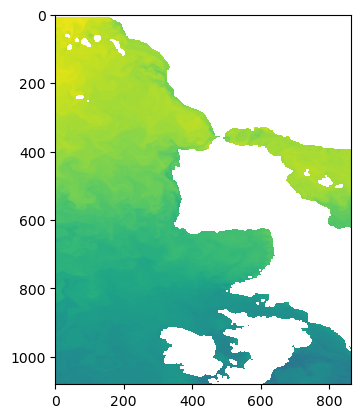

In [70]:
plt.imshow(test_surf_all['red_sst_2021-05-29'])

## Choose window over geographic area

In [80]:
test_dataset["sst_2021-05-29"]["thetao"].shape

(1, 50, 1081, 865)

In [81]:
len(test_dataset["sst_2021-05-29"]["thetao"])

1

In [96]:
type(test_dataset["sst_2021-05-29"])

netCDF4._netCDF4.Dataset

In [91]:
test_area = select_geo_area(test_dataset["sst_2021-05-29"], 
                            latmin=34, latmax=56, lonmin=-18, lonmax=-10)

In [92]:
test_area.shape

(50, 791, 287)

In [93]:
type(test_area)

numpy.ma.core.MaskedArray

In [101]:
test_area_all = select_all(test_dataset, 
                           latmin=34, latmax=56, lonmin=-18, lonmax=-10)
#test_surf_all = surface_all(test_dataset, "thetao")

In [104]:
test_area_all['sst_2021-05-29'].shape

(50, 791, 287)

## Slice images to size

In [135]:
t = test_area_all['sst_2021-05-29'][0]
t.shape

(791, 287)

In [121]:
#t[:256, :256].shape

(256, 256)

In [143]:
slice_img(t, (256, 256))

Slicing image into 3 regions...
Region: 00
Region: 10
Region: 20


{'region_00': masked_array(
   data=[[19.951000213623047, 19.8700008392334, 19.820999145507812, ...,
          19.5260009765625, 19.53700065612793, 19.54400062561035],
         [19.885000228881836, 19.834999084472656, 19.812999725341797, ...,
          19.475000381469727, 19.48699951171875, 19.49700164794922],
         [19.84400177001953, 19.816001892089844, 19.80500030517578, ...,
          19.44099998474121, 19.44300079345703, 19.448001861572266],
         ...,
         [16.48699951171875, 16.593000411987305, 16.762001037597656, ...,
          16.83100128173828, 16.81100082397461, 16.812000274658203],
         [16.437000274658203, 16.485000610351562, 16.589000701904297, ...,
          16.868000030517578, 16.854000091552734, 16.85300064086914],
         [16.356000900268555, 16.395999908447266, 16.451000213623047, ...,
          16.898000717163086, 16.889999389648438, 16.889999389648438]],
   mask=[[False, False, False, ..., False, False, False],
         [False, False, False, ..., Fal

In [ ]:
# TODO next: 
#  1. (done) write method to slice into 256x256 images
#  2. run sequentially and store results for all downloaded data:
#      a. select_area
#      b. surface
#      c. slice
# 3. see if any values in the data need to be masked - if not:
#      a. write method to extract just numpy array (.data) from each
# 4. write method to save to file


# Idea for storing sliced regions & their timeseries:

# top dictionary: region xx : sub-dictionary
# sub-dictionary: yyyy-mm-dd : numpy array (data)

# Exploratory Analysis

In [ ]:
# TODOs:
# 0. (done) Switch to processing daily files at a time
# 1. (done) Choose & slice geographic area
# 2. Pickle dump?
# 3. (done) Flip lat/lon for plotting
# 4. Load extracted numeric values into PyTorch Dataset
#    Link: https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset
# 5. (done) Clean up imports
# 6. Create a cute image showing the regions we're using, similar to paper

https://www.earthinversion.com/utilities/reading-NetCDF4-data-in-python/

https://towardsdatascience.com/fast-and-robust-sliding-window-vectorization-with-numpy-3ad950ed62f5

https://github.com/emited/flow/blob/master/flow/modules/estimators.py#L64

https://github.com/emited/flow/blob/master/flow/datasets/nc.py

Data sources:
1. https://data.marine.copernicus.eu/product/IBI_ANALYSISFORECAST_PHY_005_001/description
2. https://help.marine.copernicus.eu/en/articles/6444313-how-to-fetch-marine-data-from-copernicus-marine-ftp-server-in-python